In [57]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
import math
import matplotlib.pyplot as plt

def yuv_to_rgb(yuv: torch.Tensor, clamp=True) -> torch.Tensor:
    m = torch.tensor([
        [1, 0.00000, 1.28033],
        [1,-0.21482,-0.38059],
        [1, 2.12798, 0.00000]], 
        device=yuv.device)
    rgb = (m @ yuv.flatten(-2)).view(yuv.shape)
    return rgb.clamp(0,1) if clamp else rgb

def padcat(tensors, dim=0, pad_mode="constant", pad_value=0):
    assert len(tensors) > 0
    ndims = tensors[0].dim()
    if dim < 0: dim += ndims
    for t in tensors[1:]: assert t.dim() ==  ndims
    new_shape = [max([t.shape[d] for t in tensors]) if d != dim else -1 for d in range(ndims)]
    padding = [[new_shape[d//2] - t.shape[d//2] if (d & 1 and d//2 != dim) else 0 for d in range(ndims*2,0,-1)] for t in tensors]
    return torch.cat([F.pad(t,p,pad_mode,pad_value) for t,p in zip(tensors,padding)], dim=dim)

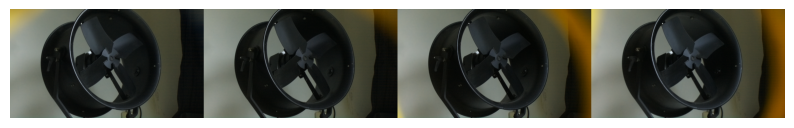

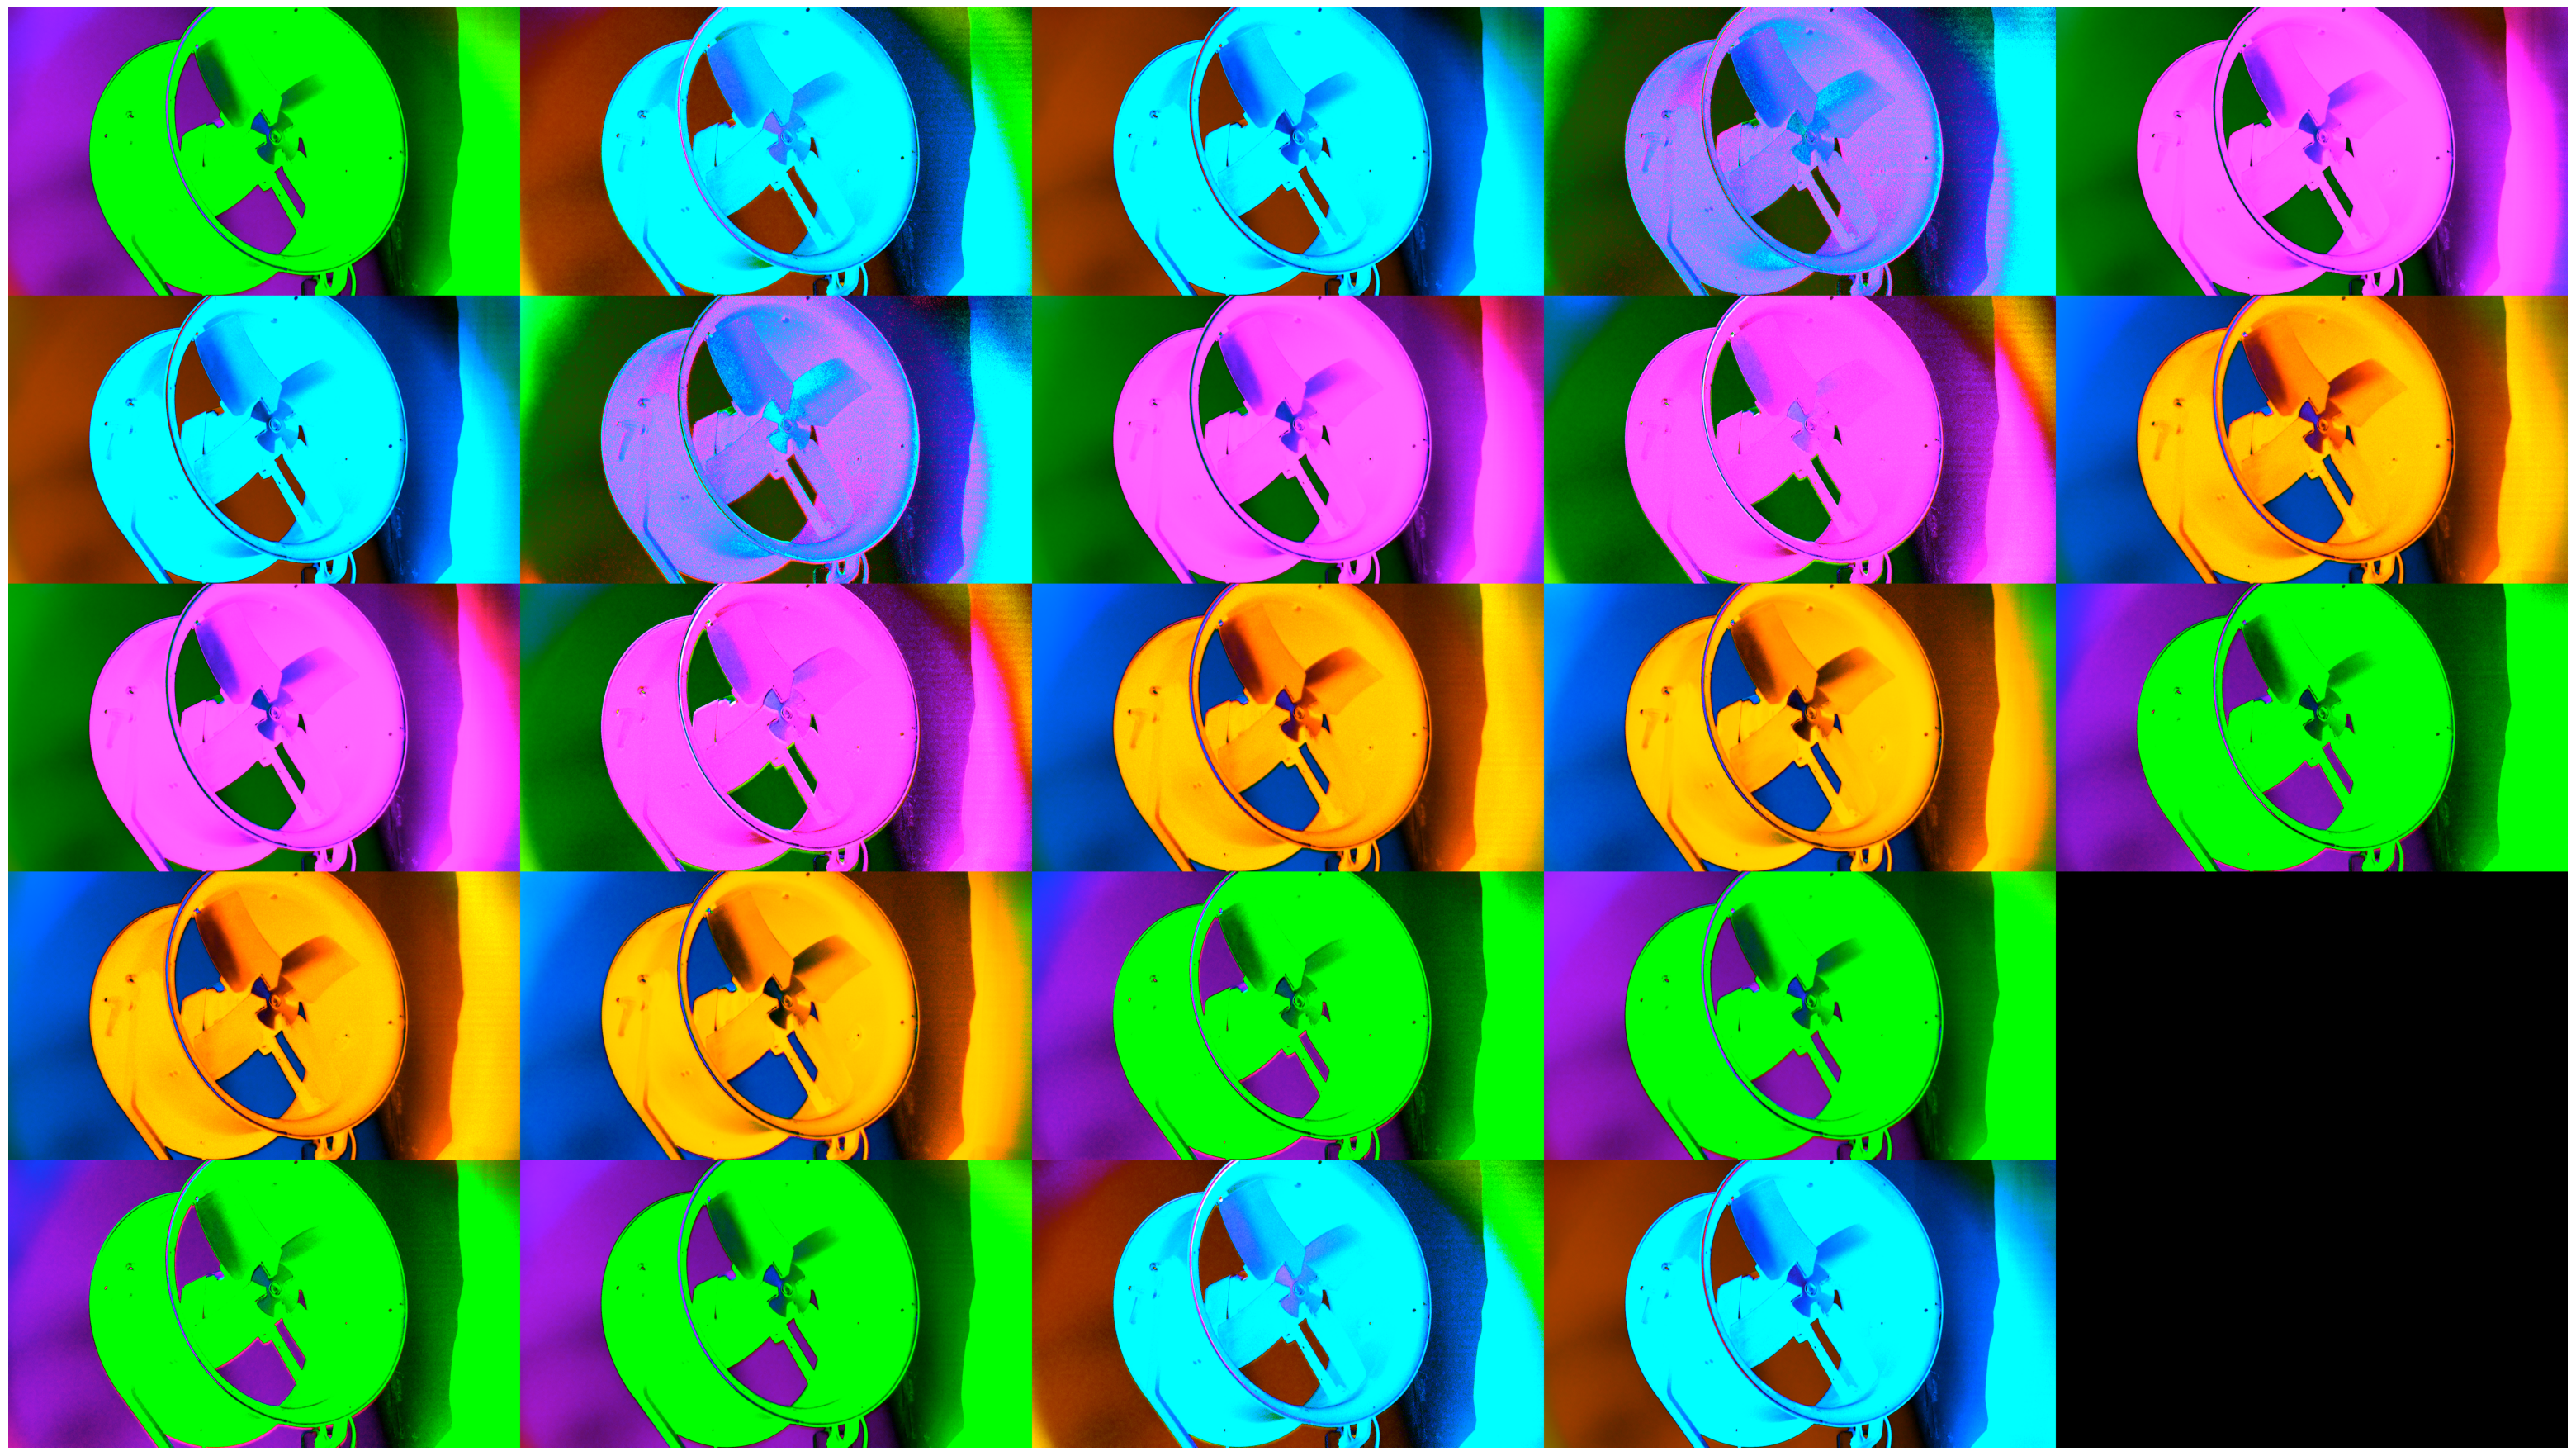

done.


In [67]:
width = 1280
height = 720
num_frames = 30

video = []
with open("/home/wipkat/projects/polarcam/test.yuv", "rb") as stream:
    for i in range(num_frames):
        b = stream.read(int(width*height*1.5))
        size = width * height
        y,u,v = torch.frombuffer(b, dtype=torch.uint8).div(255).split([size, size//4, size//4])
        y = y.view(height,width)
        u = u.view(1,1,height//2,width//2)-0.5
        v = v.view(1,1,height//2,width//2)-0.5
        u = F.interpolate(u, (height,width), mode="bilinear")[0,0]
        v = F.interpolate(v, (height,width), mode="bilinear")[0,0]
        yuv = torch.stack((y,u,v))
        video.append(yuv)
        
video = torch.stack(video)
rgb = yuv_to_rgb(video)

# Show 4 RGB frames
plt.figure(figsize=(10,60))
plt.axis("off")
plt.imshow(torch.cat(rgb[:4].split(1,dim=0),-1)[0].permute(1,2,0))
plt.show()

# Calculate the polarimetric image
fps = 30.01
rps = 1000/150
angle_per_frame = math.pi * rps / fps
basis = 7

output = []
for offset in range(video.shape[0]-basis):
    angles = torch.arange(offset, basis+offset) * angle_per_frame;
    angles = torch.complex(angles.cos(), angles.sin())[:,None,None]
    pol = video[offset:basis+offset,0] * angles
    pol = pol.pow(2)
    pol = pol.sum(0) /  pol.abs().sum(0).add(1e-3)
    mean = angles.pow(2).mean()
    pol = pol.sub(mean)
    pol.real /= pol.real.std() * 2
    pol.imag /= pol.imag.std() * 2
    pol = yuv_to_rgb(torch.stack((pol.abs() * 0.7, pol.real, pol.imag)))
    output.append(pol)

output=torch.stack(output,0)
output = output.permute(0,2,3,1)
output = output.expand(-1,-1,-1,3)
grid = output
grid = padcat(grid.split(5),-2)
grid = padcat(grid.split(1),-3)
grid = grid[0]

plt.figure(figsize=(40,60))
plt.axis("off")
plt.imshow(grid)
plt.show()

torchvision.io.write_video("test_fan.mp4", output.mul(255).byte(), fps=5, video_codec="hevc_nvenc", options={"qmin":"24", "qmax":"24", "profile":"main10"}) 
print("done.")
